In [61]:
from pyspark import keyword_only
from pyspark.sql import Column, DataFrame, SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pandas as pd
from typing import Optional
from pyspark.ml import Estimator, Model, Pipeline, Transformer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, Imputer, MinMaxScaler
from pyspark.ml.param import Param, Params, TypeConverters
from pyspark.ml.param.shared import HasInputCol, HasInputCols, HasOutputCol, HasOutputCols
from pyspark.ml.stat import Correlation
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns

Data cleaning and feature engineering steps taken:

- Sanitise column names:
    - lower the case
    - fix punctuation, spacing, nonprintable characters

- Remove illogical and irrelevant records

- Remove macronutrient values above the 99th percentile

- Create ratio features (proprortions of calories made up by each macronutrient)

- Impute the mean of continuous features

In [2]:
# Allocate 8GB of RAM to the driver
spark = (
    SparkSession.builder.appName("Dessert or Not?")
    .config("spark.driver.memory", "8g")
    .getOrCreate()
)

# Set the maximum number of pd rows to display to make data exploration easier
pd.set_option("display.max_rows", 1000) 


### Exploratory Data Analysis

In [3]:
food = spark.read.csv('./data/epi_r.csv', inferSchema=True, header=True)

print(food.count(), len(food.columns))

food.printSchema()

20057 680
root
 |-- title: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- calories: string (nullable = true)
 |-- protein: double (nullable = true)
 |-- fat: double (nullable = true)
 |-- sodium: double (nullable = true)
 |-- #cakeweek: double (nullable = true)
 |-- #wasteless: double (nullable = true)
 |-- 22-minute meals: double (nullable = true)
 |-- 3-ingredient recipes: double (nullable = true)
 |-- 30 days of groceries: double (nullable = true)
 |-- advance prep required: double (nullable = true)
 |-- alabama: double (nullable = true)
 |-- alaska: double (nullable = true)
 |-- alcoholic: double (nullable = true)
 |-- almond: double (nullable = true)
 |-- amaretto: double (nullable = true)
 |-- anchovy: double (nullable = true)
 |-- anise: double (nullable = true)
 |-- anniversary: double (nullable = true)
 |-- anthony bourdain: double (nullable = true)
 |-- aperitif: double (nullable = true)
 |-- appetizer: double (nullable = true)
 |-- apple: double (nullabl

Many columns contain undesirable characters such as # (from hashtags), and invalid characters. These should be standardised.

In [4]:
def sanitize_column_name(name):
    """Remove unwanted characters from a column name."""
    out = name
    for i, j in ((" ", "_"), ("-", "_"), ("/", "_"), ("&", "and")):
        out = out.replace(i, j)
    # Keep only letters, numbers and underscores
    return "".join(
        [char for char in out if char.isalpha() or char.isdigit() or char == "-"]
    )

In [5]:
food = food.toDF(*[sanitize_column_name(name) for name in food.columns])

Identify binary columns 

In [6]:
is_binary = food.agg(
    # If the number of distinct values in the column is 2, then it's probably binary
    *[(F.size(F.collect_set(x)) == 2).alias(x) for x in food.columns]
).toPandas()

# Unpivot the dataframe to make it easier to read in the terminal
is_binary.unstack().sort_values()

title                  0    False
rating                 0    False
calories               0    False
protein                0    False
fat                    0    False
sodium                 0    False
cakeweek               0    False
wasteless              0    False
passionfruit           0     True
passover               0     True
pasta                  0     True
pastamaker             0     True
pastry                 0     True
pea                    0     True
peach                  0     True
peanut                 0     True
pecan                  0     True
peanutfree             0     True
pear                   0     True
pasadena               0     True
pennsylvania           0     True
pepper                 0     True
pernod                 0     True
persiannewyear         0     True
persimmon              0     True
peanutbutter           0     True
party                  0     True
paris                  0     True
parsley                0     True
orange        

`cakeweek` and `wasteless` do not appear to be binary:

In [7]:
# Show the distinct values for the suspect columns
food.agg(*[F.collect_set(x) for x in ("cakeweek", "wasteless")]).show(1, False)

# Show the first and last few records with non-binary values to check for data alignment issues
(
    food
    .where("cakeweek > 1.0 or wasteless > 1.0")
    .select("title", "rating", "wasteless", "cakeweek", food.columns[-1])
    .show(truncate=False)
)

+-------------------------------+----------------------+
|collect_set(cakeweek)          |collect_set(wasteless)|
+-------------------------------+----------------------+
|[0.0, 1.0, 1188.0, 24.0, 880.0]|[0.0, 1.0, 1439.0]    |
+-------------------------------+----------------------+

+----------------------------------------------------------------+------------------------+---------+--------+------+
|title                                                           |rating                  |wasteless|cakeweek|turkey|
+----------------------------------------------------------------+------------------------+---------+--------+------+
|"Beet Ravioli with Pine Nut ""Goat Cheese"" Rosemary-Cream Sauce| Aged Balsamic Vinegar "|0.0      |880.0   |0.0   |
|"Seafood ""Cataplana"" with Saffron                             | Vermouth               |1439.0   |24.0    |0.0   |
|"""Pot Roast"" of Seitan                                        | Aunt Gloria-Style "    |0.0      |1188.0  |0.0   |
+-----

Since this is only a small number of records compared to the total dataset size, we remove them.

In [8]:
# Keep only legit values for cakeweek and wasteless
food = (
    food.where(
        (F.col("cakeweek").isin([0.0, 1.0]) | F.col("cakeweek").isNull())
        &
        (F.col("wasteless").isin([0.0, 1.0]) | F.col("wasteless").isNull())   
    )
)

print(food.count(), len(food.columns))

20054 680


Classifying variable types

In [9]:
# Columns containing information unique to each record
IDENTIFIERS = ["title"]

# Columns containing ML features
CONTINUOUS_COLUMNS = [
    "rating",
    "calories",
    "protein",
    "fat",
    "sodium"
]

# Columns containing the features we wish to predict
TARGET_COLUMN = ["dessert"]

# Columns containing binary features
BINARY_COLUMNS = [
    x for x in food.columns 
    if x not in CONTINUOUS_COLUMNS 
    and x not in TARGET_COLUMN
    and x not in IDENTIFIERS
]

We remove records that have only `null` values. After that, we equate `null` to `False` and fill zero as a default value. 

In [10]:
# Remove records that have only null values
food = food.dropna(
    how="all",
    subset=[x for x in food.columns if x not in IDENTIFIERS]
)

food = food.dropna(subset=TARGET_COLUMN)

print(food.count(), len(food.columns))

20049 680


In [11]:
food = food.fillna(0.0, subset=BINARY_COLUMNS)

print(food.where(F.col(BINARY_COLUMNS[0]).isNull()).count())

0


Cleaning continuous columns

In [12]:
# If the value is not null, try casting it to a float.
# If this fails, it's not a number.
@F.udf(T.BooleanType())
def is_a_number(value: Optional[str]) -> bool:
    if not value:
        return True
    try:
        _ = float(value)
    except ValueError:
        return False
    return True

In [13]:
# Show non-numerical values in the continuous columns
food.where(~is_a_number(F.col("rating"))).select(*CONTINUOUS_COLUMNS).show()

+---------+------------+-------+----+------+
|   rating|    calories|protein| fat|sodium|
+---------+------------+-------+----+------+
| Cucumber| and Lemon "|   3.75|null|  null|
+---------+------------+-------+----+------+



In [14]:
# Remove rogue continuous column values, cast remaining values to double
for column in CONTINUOUS_COLUMNS:
    food = food.where(is_a_number(F.col(column)))
    food = food.withColumn(column, F.col(column).cast(T.DoubleType()))

print(food.count(), len(food.columns))

20048 680


We examine the summary statistics of our continuous columns to look for remaining non-sensible values.

In [15]:
food.select(CONTINUOUS_COLUMNS).summary(
    "mean",
    "stddev",
    "min",
    "1%",
    "5%",
    "50%",
    "95%",
    "99%",
    "max"
).show()

+-------+------------------+------------------+------------------+-----------------+-----------------+
|summary|            rating|          calories|           protein|              fat|           sodium|
+-------+------------------+------------------+------------------+-----------------+-----------------+
|   mean| 3.714460295291301|6324.0634571930705|100.17385283565179|346.9398083953107|6226.927244193346|
| stddev|1.3409187660508959|359079.83696340164|3840.6809971287403|20458.04034412409|333349.5680370268|
|    min|               0.0|               0.0|               0.0|              0.0|              0.0|
|     1%|               0.0|              18.0|               0.0|              0.0|              1.0|
|     5%|               0.0|              62.0|               0.0|              0.0|              5.0|
|    50%|             4.375|             331.0|               8.0|             17.0|            294.0|
|    95%|               5.0|            1315.0|              75.0|       

Some remaining nutrition values are very high (way higher than the 75th percentile). We cap the values at the 99th percentile.

NOTE: We don't remove null values here because we later IMPUTE them using `Imputer`.

In [16]:
# Remove rows with values above the 99th percentile.
# Use hardcoded maxima to ensure analysis is consistent across runs.
maximum = {
    "calories": 3184.0,
    "protein": 173.0,
    "fat": 207.0,
    "sodium": 5649.0
}

# Replace large values while holding onto null values:
for k, v in maximum.items():
    food = food.withColumn(
        k,
        F.when(F.isnull(F.col(k)), F.col(k)).otherwise(
            F.least(F.col(k), F.lit(v))
        )
    )   

Weed out binary columns which are not present enough to be reliable predictors. 

In [17]:
# Remove binary features that occur too little or too often
# We choose a threshold of 10.
inst_sum_of_binary_columns = [
    F.sum(F.col(x)).alias(x) for x in BINARY_COLUMNS
]

# Using .head() brings data back from the distributed cluster
# to the Spark driver
sum_of_binary_columns = (
    food.select(*inst_sum_of_binary_columns).head().asDict()
)

num_rows = food.count()
# If the count of the ones / sum of the column is below 10 or above
# the number of records - 10, we remove the column.
too_rare_features = [
    k for k, v in sum_of_binary_columns.items()
    if v < 10 or v > (num_rows - 10)
]

# Rather than deleting the columns from the food dataframe, we remove
# them from the BINARY_COLUMNS list
BINARY_COLUMNS = list(set(BINARY_COLUMNS) - set(too_rare_features))

len(too_rare_features)

print(too_rare_features)

['cakeweek', 'wasteless', '30daysofgroceries', 'alabama', 'alaska', 'anthonybourdain', 'applejuice', 'arizona', 'aspen', 'atlanta', 'australia', 'beverlyhills', 'biscuit', 'boston', 'bran', 'brooklyn', 'brownie', 'buffalo', 'bulgaria', 'burrito', 'cambridge', 'camping', 'canada', 'caviar', 'chicago', 'chili', 'cobblercrumble', 'columbus', 'cooklikeadiner', 'cookbookcritic', 'costamesa', 'cranberrysauce', 'crêpe', 'crmedecacao', 'cuba', 'cupcake', 'custard', 'dallas', 'denver', 'digestif', 'dominicanrepublic', 'doriegreenspan', 'eaudevie', 'eggnog', 'egypt', 'emerillagasse', 'england', 'entertaining', 'epiushg', 'epilovesthemicrowave', 'flatbread', 'frankenrecipe', 'freezerfood', 'friendsgiving', 'frittata', 'fritter', 'germany', 'grains', 'grandmarnier', 'granola', 'grappa', 'guam', 'haiti', 'hamburger', 'hawaii', 'healdsburg', 'hollywood', 'housecocktail', 'houston', 'hummus', 'icedcoffee', 'idaho', 'illinois', 'indiana', 'iowa', 'israel', 'italy', 'jamaica', 'japan', 'juicer', 'kansa

Feature engineering and refinement

- Create a few custom features using continuous feature columns
- Measure correlation between original and generated continuous features

Since we know that there are 4kcal per g of protein and 9kcal per g of fat, we can create feature columns representing the proportion of the recipe's calories that are made up by protein and fat. Perhaps desserts have a higher proportion of fat calories?

In [18]:
# Create columns representing the proportion of calories contributed
# by protein and fat
food = (
    food
    .withColumn("protein_ratio", F.col("protein") * 4 / F.col("calories"))
    .withColumn("fat_ratio", F.col("fat") * 9 / F.col("calories"))
)

# Fill the columns where NA
food = food.fillna(0.0, subset=["protein_ratio", "fat_ratio"])

# Add the new columns to the CONTINUOUS_COLUMNS list
CONTINUOUS_COLUMNS += ["protein_ratio", "fat_ratio"]

Removing highly correlated features

The `Correlation` object's `corr` method computes the correlation between features in a `Vector`.

We use the `VectorAssembler` transformer to create a `continuous_features` column containing a `Vector` of continuous features.

Correlation won't work well if we blend categorical and/or binary features together. Correlation coefficients, such as Pearson correlation coefficient, are used to quantify the strength and direction of a linear relationship between two numerical variables. They are not suitable for categorical or binary variables because these types of variables do not have a natural linear ordering or continuous values.

In [19]:
continuous_features = VectorAssembler(
    inputCols=CONTINUOUS_COLUMNS, outputCol="continuous_features"
)

# Prepare continuous columns to be transformed into a vector.
# Vector columns can't have null values, so we remove them
vector_food = food.select(CONTINUOUS_COLUMNS)
for x in CONTINUOUS_COLUMNS:
    vector_food = vector_food.where(~F.isnull(F.col(x)))

vector_variable = continuous_features.transform(vector_food)

vector_variable.select("continuous_features").show(3, False)

vector_variable.select("continuous_features").printSchema()

+---------------------------------------------------------------------+
|continuous_features                                                  |
+---------------------------------------------------------------------+
|[2.5,426.0,30.0,7.0,559.0,0.28169014084507044,0.14788732394366197]   |
|[4.375,403.0,18.0,23.0,1439.0,0.17866004962779156,0.5136476426799007]|
|[3.75,165.0,6.0,7.0,165.0,0.14545454545454545,0.38181818181818183]   |
+---------------------------------------------------------------------+
only showing top 3 rows

root
 |-- continuous_features: vector (nullable = true)



In [20]:
# Take a data frame and a Vector column and generate a single-row,
# single-column data frame containing the correlation matrix
# Uses Pearson correlation coefficient by default.
correlation = Correlation.corr(
    vector_variable, "continuous_features"
)

correlation.printSchema()

root
 |-- pearson(continuous_features): matrix (nullable = false)



In [21]:
# The resulting DenseMatrix is a column in a row in a Pyspark DataFrame.
# It is small enough to retrieve to the driver node using collect().
print(correlation.collect()[0][0])

DenseMatrix([[1.        , 0.10245367, 0.11329165, 0.11153614, 0.06527345,
              0.0944388 , 0.12994742],
             [0.10245367, 1.        , 0.75824038, 0.91812516, 0.51696382,
              0.16550589, 0.17785614],
             [0.11329165, 0.75824038, 1.        , 0.6648986 , 0.58552344,
              0.60046731, 0.10962705],
             [0.11153614, 0.91812516, 0.6648986 , 1.        , 0.42204717,
              0.12591661, 0.42567157],
             [0.06527345, 0.51696382, 0.58552344, 0.42204717, 1.        ,
              0.33942363, 0.03423813],
             [0.0944388 , 0.16550589, 0.60046731, 0.12591661, 0.33942363,
              1.        , 0.02486967],
             [0.12994742, 0.17785614, 0.10962705, 0.42567157, 0.03423813,
              0.02486967, 1.        ]])


In [22]:
correlation_array = correlation.collect()[0][0].toArray()
correlation_pd = pd.DataFrame(
    correlation_array,
    index = CONTINUOUS_COLUMNS,
    columns = CONTINUOUS_COLUMNS
)

In [23]:
# Show the Pearson correlations
print(correlation_pd)

                 rating  calories   protein       fat    sodium  \
rating         1.000000  0.102454  0.113292  0.111536  0.065273   
calories       0.102454  1.000000  0.758240  0.918125  0.516964   
protein        0.113292  0.758240  1.000000  0.664899  0.585523   
fat            0.111536  0.918125  0.664899  1.000000  0.422047   
sodium         0.065273  0.516964  0.585523  0.422047  1.000000   
protein_ratio  0.094439  0.165506  0.600467  0.125917  0.339424   
fat_ratio      0.129947  0.177856  0.109627  0.425672  0.034238   

               protein_ratio  fat_ratio  
rating              0.094439   0.129947  
calories            0.165506   0.177856  
protein             0.600467   0.109627  
fat                 0.125917   0.425672  
sodium              0.339424   0.034238  
protein_ratio       1.000000   0.024870  
fat_ratio           0.024870   1.000000  


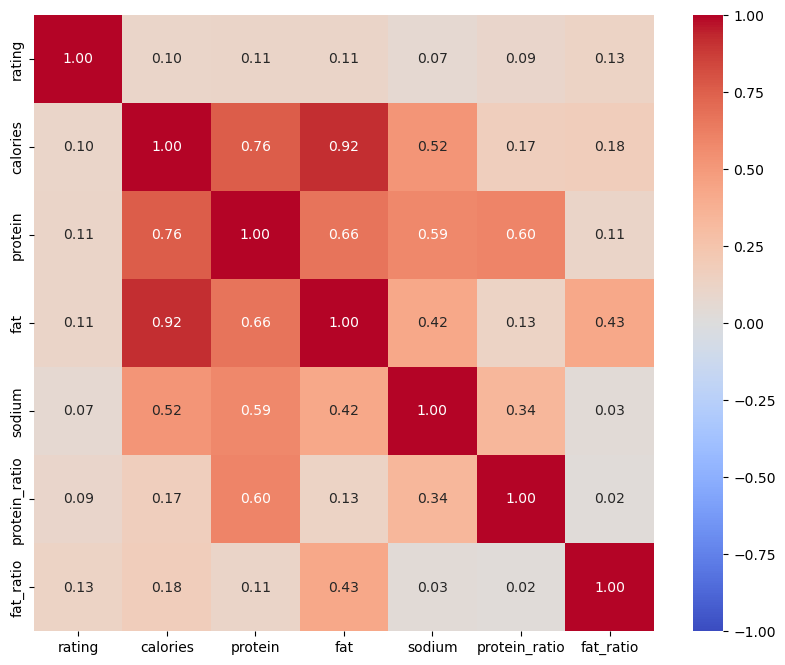

In [24]:
# Set the size of the figure for better visibility (adjust as needed)
plt.figure(figsize=(10, 8))

# Define the colormap to use (e.g., 'coolwarm', 'viridis', 'plasma', 'RdYlBu', etc.)
colormap = 'coolwarm'

# Display the heatmap with the specified colormap
sns.heatmap(correlation_pd, cmap=colormap, annot=True, fmt=".2f", vmin=-1, vmax=1)

# Show the plot
plt.show()

We see high correlation between sodium, calories, protein and fat.

- What's the relationship between calorie count and the ratio of macronutrients?
- How do calories, protein, fat and sodium relate to being a dessert or not?

Feature preparation

In [25]:
# Instantiate and apply an Imputer to create an ImputerModel

OLD_COLS = ["calories", "protein", "fat", "sodium"]
NEW_COLS = ["calories_i", "protein_i", "fat_i", "sodium_i"]

# Create imputer using mean to fill null values
imputer = Imputer(
    strategy="mean",
    inputCols=OLD_COLS,
    outputCols=NEW_COLS
)

# Create ImputerModel by applying fit() method to food DataFrame
imputer_model = imputer.fit(food)

# Put NEW_COLS into CONTINUOUS_COLUMNS, remove OLD_COLS
CONTINUOUS_COLUMNS = (
    list(set(CONTINUOUS_COLUMNS) - set(OLD_COLS)) + NEW_COLS
)

In [26]:
# Use the ImputerModel on the food DataFrame
food_imputed = imputer_model.transform(food)

In [27]:
food_imputed.where("calories is null").select("calories", "calories_i").show(5, False)

+--------+------------------+
|calories|calories_i        |
+--------+------------------+
|null    |475.33021591765004|
|null    |475.33021591765004|
|null    |475.33021591765004|
|null    |475.33021591765004|
|null    |475.33021591765004|
+--------+------------------+
only showing top 5 rows



Scale features using MinMaxScaler estimator

```Rescaled(e_i) = (e_i - E_min) / (E_max - E_min) * (max - min) + min```

In [28]:
# Scale continuous (non-ratio) variables (ratios are already between 0 and 1)
CONTINUOUS_NB = [x for x in CONTINUOUS_COLUMNS if "ratio" not in x]

# VectorAssembler is a transformer
continuous_assembler = VectorAssembler(
    inputCols = CONTINUOUS_NB, outputCol="continuous"
)

food_features = continuous_assembler.transform(food_imputed)

# MinMaxScaler is an estimator and needs to be fitted on the data
# Before it can transform anything.
# Use default values of min=0.0 and max=1.0
continuous_scaler = MinMaxScaler(
    inputCol="continuous",
    outputCol="continuous_scaled"
)

food_features = continuous_scaler.fit(food_features).transform(food_features)

food_features.select("continuous_scaled").show(3, False)

+----------------------------------------------------------------------------------------+
|continuous_scaled                                                                       |
+----------------------------------------------------------------------------------------+
|[0.5,0.13379396984924624,0.17341040462427745,0.033816425120772944,0.09895556735705434]  |
|[0.875,0.12657035175879397,0.10404624277456646,0.1111111111111111,0.25473535138962644]  |
|[0.75,0.05182160804020101,0.03468208092485549,0.033816425120772944,0.029208709506107274]|
+----------------------------------------------------------------------------------------+
only showing top 3 rows



We can create a `Pipeline` estimator whose `stages` consist of out `Imputer`, `VectorAssembler` and `MinMaxScaler`.  

In [29]:
imputer = Imputer(
    strategy="mean",
    inputCols=["calories", "protein", "fat", "sodium", "protein_ratio", "fat_ratio"],
    outputCols=["calories_i", "protein_i", "fat_i", "sodium_i", "protein_ratio_i", "fat_ratio_i"],
)

continuous_assembler = VectorAssembler(
    inputCols=["rating", "calories_i", "protein_i", "fat_i", "sodium_i"],
    outputCol="continuous"
)

continuous_scaler = MinMaxScaler(
    inputCol="continuous",
    outputCol="continuous_scaled"
)

food_pipeline = Pipeline(
    stages=[imputer, continuous_assembler, continuous_scaler]
)

PySpark requires all data fed into a machine learning estimator to be in a single vector column. 

In [30]:
# Create a vector assembler
preml_assembler = VectorAssembler(
    inputCols=BINARY_COLUMNS + ["continuous_scaled"] + ["protein_ratio", "fat_ratio"],
    outputCol="features"
)

food_pipeline.setStages(
    [imputer, continuous_assembler, continuous_scaler, preml_assembler]
)

# Create the PipelineModel and use it to transform the DataFrame
food_pipeline_model = food_pipeline.fit(food)
food_features = food_pipeline_model.transform(food)

In [31]:
# Which indices in feature vector represent each feature?
food_features.schema["features"].metadata

{'ml_attr': {'attrs': {'numeric': [{'idx': 0, 'name': 'honey'},
    {'idx': 1, 'name': 'alcoholic'},
    {'idx': 2, 'name': 'quickandhealthy'},
    {'idx': 3, 'name': 'cantaloupe'},
    {'idx': 4, 'name': 'asianpear'},
    {'idx': 5, 'name': 'raisin'},
    {'idx': 6, 'name': 'flaminghotsummer'},
    {'idx': 7, 'name': 'kahlúa'},
    {'idx': 8, 'name': 'fatfree'},
    {'idx': 9, 'name': 'feta'},
    {'idx': 10, 'name': 'scotch'},
    {'idx': 11, 'name': 'poultrysausage'},
    {'idx': 12, 'name': 'mustard'},
    {'idx': 13, 'name': 'porkchop'},
    {'idx': 14, 'name': 'salad'},
    {'idx': 15, 'name': 'pepper'},
    {'idx': 16, 'name': 'wheatglutenfree'},
    {'idx': 17, 'name': 'milkcream'},
    {'idx': 18, 'name': 'quickandeasy'},
    {'idx': 19, 'name': 'campari'},
    {'idx': 20, 'name': 'washingtondc'},
    {'idx': 21, 'name': 'cashew'},
    {'idx': 22, 'name': 'coffeegrinder'},
    {'idx': 23, 'name': 'fig'},
    {'idx': 24, 'name': 'pescatarian'},
    {'idx': 25, 'name': 'watercre

Train ML model using LogisticRegression classifier

In [32]:
# Add a LogisticRegression estimator to the pipeline
lr = LogisticRegression(
    featuresCol="features",
    labelCol="dessert",
    predictionCol="prediction"
)

food_pipeline.setStages(
    [
        imputer,
        continuous_assembler,
        continuous_scaler,
        preml_assembler,
        lr
    ]
)

Pipeline_69f191362099

In [33]:
# Split the DataFrame for training and testing

# randomSplit() takes a list of partitions, each containing the fraction of the data set.
# The second attribute is a seed for the random number generator. 
train, test = food.randomSplit([0.7, 0.3], 13)

train.cache()

# Fit the model on the train data, then transform the test data
food_pipeline_model = food_pipeline.fit(train)
results = food_pipeline_model.transform(test)

Evaluating and optimising the model

In [34]:
# Create a confusion matrix using pivot()
results.groupby("dessert").pivot("prediction").count().show()

+-------+----+---+
|dessert| 0.0|1.0|
+-------+----+---+
|    0.0|4993| 93|
|    1.0|  82|969|
+-------+----+---+



We have class imbalance of about 4:1 between non-desserts and desserts, but since this isn't severe, we won't take any specific measures to address this.

Computing precision and recall

In [35]:
# Extract the fitted model from the last step of the pipeline,
# call evaluate()
lr_model = food_pipeline_model.stages[-1]
metrics = lr_model.evaluate(results.select("title", "dessert", "features"))

print(f"Precision: {metrics.precisionByLabel[1]}")
print(f"Recall: {metrics.recallByLabel[1]}")

Precision: 0.9124293785310734
Recall: 0.9219790675547098


Receiver Operating Characteristic (ROC) Curve

One way of interpreting the area under the curve (AUC) is as the probability that the model ranks a random positive example more highly than a random negative example.

TPR = TP / (TP + FN)
FPR = FP / (FP + TN)

In [36]:
# Create a BinaryClassificationEvaluator object to get the area
# under the ROC curve (a measure of accuracy):
evaluator = BinaryClassificationEvaluator(
    labelCol="dessert",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

accuracy = evaluator.evaluate(results)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9932232209236158


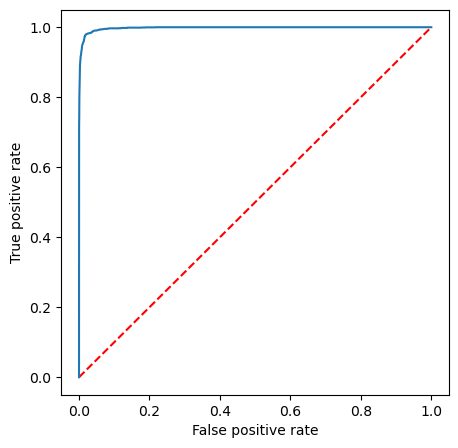

In [37]:
# Plot the ROC curve
plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], "r--")
# Plot false false positive rate against true positive rate
plt.plot(
    lr_model.summary.roc.select("FPR").collect(),
    lr_model.summary.roc.select("TPR").collect()
)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

99.32% of the area is under the ROC curve. It appears the model is performing quite well.

Model optimisation

By fine-tuning some of the `LogisticRegression` parameters, we can probably get an even better model accuracy.

We first use `ParamGridBuilder` to create a set of hyperparameters that we want to evaluate the model against.

The elastic net mixing parameter, denoted by alpha (`α`), is used to control the balance between L1 and L2 regularization. It takes values between 0 and 1, where:

- `α = 0`: Pure L2 regularization (Ridge regression).
- `α = 1`: Pure L1 regularization (Lasso regression).
- `0 < α < 1`: Elastic Net regularization, a combination of L1 and L2.

By adjusting the value of alpha, you can control the sparsity of the model (the number of non-zero coefficients). When `α` is close to 1, many coefficients may become exactly zero, leading to feature selection. On the other hand, when `α` is close to 0, the model behaves more like Ridge regression, and most coefficients remain non-zero.

We build a set of hyperparameters to evaluate against containing `α = 0` and `α = 1`.

In [38]:
# Use ParamGridBuilder to build a set of hyperparameters.
grid_search = (
    ParamGridBuilder()
    .addGrid(lr.elasticNetParam, [0.0, 1.0])
    .build()
)

grid_search

[{Param(parent='LogisticRegression_0e72ddf90b75', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0},
 {Param(parent='LogisticRegression_0e72ddf90b75', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 1.0}]

We perform k-fold cross-validation with `k = 3` folds. For each element of the grid, PySpark will perform three train-validation splits, fit the model on the train portion (which contains 2/3 of the data), and then evaluate the performance metric selected on the validation set (which contains the remaining 1/3).

In [39]:
# Create and use a CrossValidator object.
# We use the same BinaryClassificationEvaluator that we created earlier
# to evaluate performance.
cv = CrossValidator(
    estimator=food_pipeline,
    estimatorParamMaps=grid_search,
    evaluator=evaluator,
    numFolds=3,
    seed=13,
    collectSubModels = True
)

cv_model = cv.fit(train)

In [40]:
# Use avgMetrics to extract the areaUnderROC accuracy metric
cv_model.avgMetrics

[0.9891365250354031, 0.9891349528508768]

`α = 0`, i.e. Pure L2 regularization (Ridge regression) gives us the largest areaUnderROC, by a thin margin. We extract this so that we can use it as our pipeline model.

In [41]:
pipeline_food_model = cv_model.bestModel

Model explainability: which coefficients are the biggest drivers?

In [42]:
# Extract the feature names from the features vector.
# We add the intercept manually.
feature_names = ["(Intercept)"] + [
    x["name"] for x in (
        food_features.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]
    )
]

# Add the intercept manually from the intercept slot
feature_coefficients = [lr_model.intercept] + list(lr_model.coefficients.values)

# Create DataFrame of feature labels and coefficients
coefficients = pd.DataFrame(feature_coefficients, index=feature_names, columns=["coef"])

# Add a column of absolute values for convenient sorting
coefficients["abs_coef"] = coefficients["coef"].abs()

coefficients.sort_values(["abs_coef"], ascending=False)

,coef,abs_coef
cauliflower,-17.820131,17.820131
horseradish,-16.187201,16.187201
coffeegrinder,-15.317277,15.317277
goose,-14.871704,14.871704
rye,-14.060035,14.060035
cabbage,-13.870852,13.870852
squid,-13.575995,13.575995
lowsugar,-13.545976,13.545976
leafygreen,-13.475239,13.475239
bulgur,-13.470171,13.470171


Terms with coefficients close to zero like `blender`, `quince` and `cinnamon` are not very predictive or whether or not a recipe is a dessert, whereas terms like `cauliflower`, `horseradish` and `coffeegrinder` are highly predictive. 

In [43]:
# Save the model
pipeline_food_model.write().overwrite().save("dessert-or-not-model")

In [44]:
test_df = spark.createDataFrame(
    [
        [1, 2, 4, 1], 
        [3, 6, 5, 4], 
        [9, 4, None, 9], 
        [11, 17, None, 3]
    ], 
    ["one", "two", "three", "four"]
)

In [45]:
def scalarNAFillerFunction(
        df: DataFrame,
        inputCol: Column,
        outputCol: str,
        filler: float = 0.0
):
    return df.withColumn(outputCol, inputCol).fillna(filler, subset=outputCol)

In [46]:
scalarNAFillerFunction(test_df, F.col("three"), "five", -99.0).show()

+---+---+-----+----+----+
|one|two|three|four|five|
+---+---+-----+----+----+
|  1|  2|    4|   1|   4|
|  3|  6|    5|   4|   5|
|  9|  4| null|   9| -99|
| 11| 17| null|   3| -99|
+---+---+-----+----+----+



In [62]:
# Define a ScalarNAFiller transformer
# inputCol and outputCol are defined through Mixin classes, HasInputCol and HasOutputCol
class ScalarNAFiller(Transformer, HasInputCol, HasOutputCol, HasInputCols, HasOutputCols):
    
    # Initialiser method
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None, inputCols=None, outputCols=None, filler=None):
        super().__init__()
        self._setDefault(filler=None)
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    # Create a filler Param using the Param class
    filler = Param(
    Params._dummy(),
    "filler",
    "Value we want to replace our null values with.",
    typeConverter=TypeConverters.toFloat
    )

    @keyword_only
    def setParams(self, *, inputCol=None, outputCol=None, inputCols=None, outputCols=None, filler=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)
    
    def setFiller(self, new_filler):
        return self.setParams(filler=new_filler)
    
    def getFiller(self):
        return self.getOrDefault(self.filler)
    
    def setInputCol(self, new_inputCol):
        return self.setParams(inputCol=new_inputCol)
    
    def setOutputCol(self, new_outputCol):
        return self.setParams(outputCol=new_outputCol)
    
    def setInputCols(self, new_inputCols):
        return self.setParams(inputCols=new_inputCols)

    def setOutputCols(self, new_outputCols):
        return self.setParams(outputCols=new_outputCols)
    
    def checkParams(self):
        # Test #1: either inputCol or inputCols can be set (but not both).
        if self.isSet("inputCol") and (self.isSet("inputCols")):
            raise ValueError(
                "Only one of `inputCol` and `inputCols`" "must be set."
            )

        # Test #2: at least one of inputCol or inputCols must be set.
        if not (self.isSet("inputCol") or self.isSet("inputCols")):
            raise ValueError(
                "One of `inputCol` or `inputCols` must be set."
            )

        # Test #3: if `inputCols` is set, then `outputCols`
        # must be a list of the same len()
        if self.isSet("inputCols"):
            if len(self.getInputCols()) != len(self.getOutputCols()):
                raise ValueError(
                    "The length of `inputCols` does not match"
                    " the length of `outputCols`"
                )
    
    def _transform(self, dataset):
        # Check the validity of the params before doing anything else
        self.checkParams()

        # Wrap single params in lists so that we can iterate over them
        input_columns = (
            [self.getInputCol()]
            if self.isSet("inputCol")
            else self.getInputCols()
        )
        output_columns = (
            [self.getOutputCol()]
            if self.isSet("outputCol")
            else self.getOutputCols()
        )

        answer = dataset

        # When input and output columns are the same, save operations
        # by overwriting the existing ones, no need to create new ones
        if input_columns != output_columns:
            for in_col, out_col in zip(input_columns, output_columns):
                answer = answer.withColumn(out_col, F.col(in_col))

        na_filler = self.getFiller()
        return answer.fillna(na_filler, output_columns)

    pass

In [48]:
# Instantiate and test the ScalarNAFiller transformer
test_ScalarNAFiller = ScalarNAFiller(
    inputCol="three", outputCol="five", filler=-99
)

test_ScalarNAFiller.transform(test_df).show()

+---+---+-----+----+-----+
|one|two|three|four| five|
+---+---+-----+----+-----+
|  1|  2|    4|   1|  4.0|
|  3|  6|    5|   4|  5.0|
|  9|  4| null|   9|-99.0|
| 11| 17| null|   3|-99.0|
+---+---+-----+----+-----+



In [49]:
def test_ExtremeValueCapperModel_transform(
        df: DataFrame,
        inputCol: Column,
        outputCol: str,
        cap: float,
        floor: float
):
    return df.withColumn(
        outputCol,
        F.when(inputCol > cap, cap)
        .when(inputCol < floor, floor)
        .otherwise(inputCol)
    )

def test_ExtremeCalueCapper_fit(
        df: DataFrame, inputCol: Column, outputCol: str, boundary: float
):
    # Return the first and only record of the aggregated DataFrame 
    avg, stddev = df.agg(
        F.mean(inputCol, F.stddev(inputCol))
    ).head()

    cap = avg + boundary * stddev
    floor = avg - boundary * stddev
    return test_ExtremeValueCapperModel_transform(
        df, inputCol, outputCol, cap, floor
    )

In [52]:
# Implement _ExtremeValueCapperParams Mixin
class _ExtremeValueCapperParams(HasInputCol, HasOutputCol):

    boundary = Param(
        Params._dummy(),
        "boundary",
        "Multiple of standard deviation for the cap and floor. Default = 0.0.",
        TypeConverters.toFloat
    )

    # Set the default value of the boundary Param
    def __init__(self, *args):
        super().__init__(*args)
        self._setDefault(boundary=0.0)

    def getBoundary(self):
        return self.getOrDefault(self.boundary)

In [56]:
# Implement ExtremeValueCapperModel
class ExtremeValueCapperModel(Model, _ExtremeValueCapperParams):

    cap = Param(
        Params._dummy(),
        "cap",
        "Upper bound of the values `inputCol` can take."
        "Values will be capped to this value.",
        TypeConverters.toFloat,
    )
    floor = Param(
        Params._dummy(),
        "floor",
        "Lower bound of the values `inputCol` can take."
        "Values will be floored to this value.",
        TypeConverters.toFloat,
    )

    @keyword_only
    def __init__(
        self, inputCol=None, outputCol=None, cap=None, floor=None
    ):
        super().__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(
        self, inputCol=None, outputCol=None, cap=None, floor=None
    ):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def setCap(self, new_cap):
        return self.setParams(cap=new_cap)

    def setFloor(self, new_floor):
        return self.setParams(floor=new_floor)

    def setInputCol(self, new_inputCol):
        return self.setParams(inputCol=new_inputCol)

    def setOutputCol(self, new_outputCol):
        return self.setParams(outputCol=new_outputCol)

    def getCap(self):
        return self.getOrDefault(self.cap)

    def getFloor(self):
        return self.getOrDefault(self.floor)

    def _transform(self, dataset):
        if not self.isSet("inputCol"):
            raise ValueError(
                "No input column set for the ExtremeValueCapperModel transformer."
            )
        input_column = dataset[self.getInputCol()]
        output_column = self.getOutputCol()
        cap_value = self.getOrDefault("cap")
        floor_value = self.getOrDefault("floor")

        return dataset.withColumn(
            output_column,
            F.when(input_column > cap_value, cap_value)
            .when(input_column < floor_value, floor_value)
            .otherwise(input_column)
        )

In [59]:
# Implement _fit() method of ExtremeValueCapper
class ExtremeValueCapper(Estimator, _ExtremeValueCapperParams):
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None, boundary=None):
        super().__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None, boundary=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def setBoundary(self, new_boundary):
        self.setParams(boundary=new_boundary)

    def setInputCol(self, new_inputCol):
        return self.setParams(inputCol=new_inputCol)

    def setOutputCol(self, new_outputCol):
        return self.setParams(outputCol=new_outputCol)
    
    def _fit(self, dataset):
        input_column = self.getInputCol()
        output_column = self.getOutputCol()
        boundary = self.getBoundary()

        # Compute average and standard deviation from passed dataset
        avg, stddev = dataset.agg(
            F.mean(input_column), F.stddev(input_column)
        ).head()

        cap_value = avg + boundary * stddev
        floor_value = avg - boundary * stddev
        # Return a full Param-eterised ExtremeValueCapperModel
        return ExtremeValueCapperModel(
            inputCol=input_column,
            outputCol=output_column,
            cap=cap_value,
            floor=floor_value
        )

In [60]:
# Test the ExtremeValueCapper on a sample DataFrame
test_EVC = ExtremeValueCapper(
    inputCol="one", outputCol="five", boundary=1.0
)

test_EVC.fit(test_df).transform(test_df).show()

+---+---+-----+----+------------------+
|one|two|three|four|              five|
+---+---+-----+----+------------------+
|  1|  2|    4|   1|1.2390477143047667|
|  3|  6|    5|   4|               3.0|
|  9|  4| null|   9|               9.0|
| 11| 17| null|   3|10.760952285695232|
+---+---+-----+----+------------------+



We use the custom transformers and estimators we've defined here with the `calories`, `protein`, `fat` and `sodium` columns of the food DataFrame in our pipeline.

In [ ]:
# Instantiate custom transformers and estimators for the pipeline

scalar_na_filler = ScalarNAFiller(
    inputCols=BINARY_COLUMNS, outputCols=BINARY_COLUMNS, filler=0.0
)

extreme_value_capper_cal = ExtremeValueCapper(
    inputCol="calories", outputCol="calories", boundary=2.0
)

extreme_value_capper_pro = ExtremeValueCapper(
    inputCol="protein", outputCol="protein", boundary=2.0
)

extreme_value_capper_fat = ExtremeValueCapper(
    inputCol="fat", outputCol="fat", boundary=2.0
)

extreme_value_capper_sod = ExtremeValueCapper(
    inputCol="sodium", outputCol="sodium", boundary=2.0
)

In [ ]:
# Use custom transformers and estimators in an improved version of the pipeline
food_pipeline = Pipeline(
    stages = [
        scalar_na_filler,
        extreme_value_capper_cal,
        extreme_value_capper_pro,
        extreme_value_capper_fat,
        extreme_value_capper_sod,
        imputer,
        continuous_assembler,
        continuous_scaler,
        preml_assembler,
        lr
    ]
)